> # Daily Temperatures EDA (Global, Europe, Austria)

This exploratory analysis looks at global temperatures between 1995 and 2019 and explores Europe and Austria in more detail.

Data from: https://www.kaggle.com/sudalairajkumar/daily-temperature-of-major-cities

## Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
from tqdm import tqdm_notebook as tqdm
import datetime
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
df = pd.read_csv("../input/daily-temperature-of-major-cities/city_temperature.csv", low_memory = False)

## Memory usage

Having a first look at the dataframe, I see that there's information about the region, country, state (in case of the US), city, date and average temperatuer (in Fahrenheit). 

In [7]:
df.sample(5)

,Region,Country,State,City,Month,Day,Year,AvgTemperature
1162014,North America,Canada,NaN,Ottawa,7,25,2007,71.4
539875,Asia,Thailand,NaN,Bangkok,7,16,2011,81.2
34732,Africa,Congo,NaN,Brazzaville,7,19,2001,74.2
1553015,North America,US,Arkansas,Little Rock,11,22,1998,48.4
133777,Africa,Mauritania,NaN,Nouakchott,7,4,1998,88.5


I noticed that my computer takes quite a while to process the dataframe,so I have a look at its memory usage.

In [8]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Region          object 
 1   Country         object 
 2   State           object 
 3   City            object 
 4   Month           int64  
 5   Day             int64  
 6   Year            int64  
 7   AvgTemperature  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 767.7 MB


In [9]:
df.memory_usage(deep=True)

Index                   128
Region            200858229
Country           179884611
State             141323998
City              189912136
Month              23250616
Day                23250616
Year               23250616
AvgTemperature     23250616
dtype: int64

Since the dataframe takes 767.7 MB and has almost 3 million rows, I decide to decrease its memory usage in order to be able to work with it a little bit faster.

First, I convert the data type of some of the columns. Month and Day are converted from int64 to int 8 (as they only take on a max. value of 12 and 31, respectively), Year is converted from int64 to int16 (only takes on a max. values of 2020), and AvgTemperature is converted from float64 to float16.

In [10]:
df[['Month', 'Day']] = df[['Month', 'Day']].astype('int8')
df[['Year']] = df[['Year']].astype('int16')
df['AvgTemperature'] = df['AvgTemperature'].astype('float16')

In [11]:
df.reset_index(drop=True, inplace=True)

In [12]:
df.sample(5)

,Region,Country,State,City,Month,Day,Year,AvgTemperature
1016059,Middle East,Israel,NaN,Tel Aviv,11,27,1998,70.625000
1341934,South/Central America & Carribean,Dominican Republic,NaN,Santo Domingo,10,6,2004,78.625000
1977378,North America,US,Kentucky,Paducah,2,17,2013,31.203125
733360,Europe,Germany,NaN,Bonn,8,5,2001,-99.000000
2239335,North America,US,New Hampshire,Concord,3,16,2004,31.796875


## Data cleaning


First of all, there are some ambiguous year values in the dataframe, so I drop them. I also drop all data from the year 2020, since there is no data available for the whole year yet.

In [14]:
df = df[df.Year != 200]
df = df[df.Year != 201]
df = df[df.Year != 2020]

I also drop the column State, since it only applies to the US, which I don't want to analyze in detail.

In [15]:
df = df.drop('State', axis = 1)

Next, I create a separate datetime column. However, I leave out the Day column since I do not need to work with daily temperatures. Monthly temperatures are fine and will save me some computational cost with certain plots.

In [16]:
df['Date'] = pd.to_datetime(df.Year.astype(str) + '/' + df.Month.astype(str))

To handle any missing data, I first look at what percentage of data is missing for each country.

In [17]:
missing = pd.DataFrame(df.loc[df.AvgTemperature == -99, 'Country'].value_counts())
missing['TotalData'] = df.groupby('Country').AvgTemperature.count()
missing['PercentageMissing'] = missing.apply(lambda row: (row.Country/row.TotalData)*100, axis = 1)
missing.sort_values(by=['PercentageMissing'], inplace=True, ascending = False)
missing.head(20)

,Country,TotalData,PercentageMissing
Burundi,3659,4543,80.541492
Guyana,2929,5065,57.828233
Malawi,3052,5693,53.609696
Sierra Leone,3145,6209,50.652279
Guinea-Bissau,4083,9133,44.706011
Bangladesh,2243,5810,38.605852
Haiti,3451,9135,37.777778
Oman,2993,8917,33.565100
Germany,6977,24384,28.613025
Kenya,2139,8037,26.614408


It looks like there is a lot of data missing in Burundi, as well as in some other African, Latin American, Asian and European countries.

Since any missing temperatures are saved as -99, I convert them to NaN.

In [18]:
df.loc[df.AvgTemperature == -99, 'AvgTemperature'] = np.nan

In [19]:
df.AvgTemperature.isna().sum()

79164

I then fill the missing values with the mean temperature of the same city and of the same date every year.

In [20]:
df['AvgTemperature'] = df['AvgTemperature'].fillna(df.groupby(['City', 'Date']).AvgTemperature.transform('mean'))

In [21]:
df.AvgTemperature.isna().sum()

25627

However, it seems that for some cities, there is so much data missing, that they may not be any recorded temperature for a given date.

In [22]:
df.loc[df.AvgTemperature.isna(), 'City'].value_counts()

Bissau                  3014
Bujumbura               2401
Muscat                  2285
Freetown                2159
Lilongwe                1709
Georgetown              1397
Tirana                  1127
Port au Prince          1034
Nicosia                  853
Nairobi                  760
Addis Ababa              732
Conakry                  610
Guadalajara              608
Dusanbe                  486
Jakarta                  426
Kampala                  425
Zagreb                   396
Lagos                    367
Sofia                    366
Bangkok                  365
Rangoon                  365
Paramaribo               275
Frankfurt                274
Banjul                   273
Managua                  242
Bonn                     214
Santo Domingo            211
Tbilisi                  184
Tel Aviv                 182
Islamabad                182
Brazzaville              154
Guatemala City           150
Libreville               124
Maputo                   123
Perth         

So for those cities, I fill the missing data with the overall mean temperature of the city

In [23]:
df['AvgTemperature'] = df['AvgTemperature'].fillna(df.groupby(['City']).AvgTemperature.transform('mean'))

In [24]:
df.AvgTemperature.isna().sum()

0

Since I have a better intuition for temperatures in Celsius, I convert them.

In [27]:
# °F to °C: (°F − 32) × 5/9 = °C
df['AvgTempCelsius'] = (df.AvgTemperature -32)*(5/9)
df  = df.drop(['AvgTemperature'], axis = 1)

Finally, I round the temperatures in tow different way, once with two and once with one decimal.

In [28]:
df['AvgTempCelsius_rounded'] = df.AvgTempCelsius.apply(lambda x: "{0:0.2f}".format(x))
df['AvgTempCelsius_rounded2'] = df.AvgTempCelsius.apply(lambda x: "{0:0.1f}".format(x))

In [29]:
df['AvgTempCelsius_rounded'] = pd.to_numeric(df['AvgTempCelsius_rounded'])
df['AvgTempCelsius_rounded2'] = pd.to_numeric(df['AvgTempCelsius_rounded2'])

In [30]:
df.sample(5)

,Region,Country,City,Month,Day,Year,Date,AvgTempCelsius,AvgTempCelsius_rounded,AvgTempCelsius_rounded2
1210258,North America,Mexico,Guadalajara,2,20,2013,2013-02-01,21.218750,21.22,21.2
2032695,North America,US,Baltimore,7,5,1996,1996-07-01,21.328125,21.33,21.3
2888142,North America,US,Casper,7,12,2014,2014-07-01,20.390625,20.39,20.4
2214241,North America,US,Omaha,8,8,2011,2011-08-01,25.625000,25.62,25.6
506919,Asia,Sri Lanka,Colombo,6,1,1997,1997-06-01,30.453125,30.45,30.5


## Analysis

### Global

#### YEARLY GLOBAL AVERAGE TEMPERATURE OVER TIME

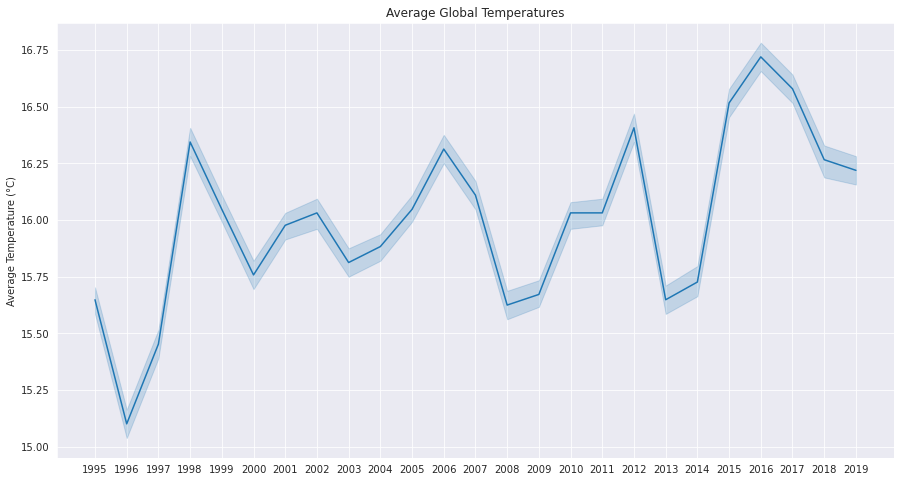

In [32]:
plt.figure(figsize=(15,8))
sns.lineplot(x = 'Year', y = 'AvgTempCelsius', data = df , palette='Set2')
plt.title('Average Global Temperatures')
plt.ylabel('Average Temperature (°C)')
plt.xlabel('')
plt.xticks(range(1995,2020))
plt.show();

#### MONTHLY GLOBAL AVERAGE TEMPERATURE OVER TIME

In [33]:
df_mean_month = df.groupby(['Month', 'Year']).AvgTempCelsius_rounded2.mean()
df_mean_month = df_mean_month.reset_index()
df_mean_month = df_mean_month.sort_values(by = ['Year'])

In [34]:
df_pivoted = pd.pivot_table(data= df_mean_month,
                    index='Month',
                    values='AvgTempCelsius_rounded2',
                    columns='Year')

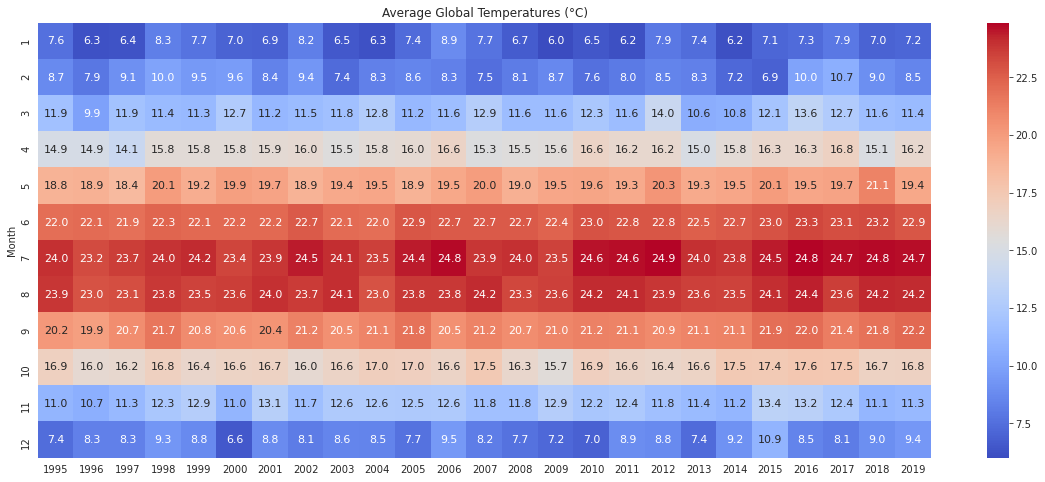

In [35]:
plt.figure(figsize=(20, 8))
sns.heatmap(data = df_pivoted, cmap='coolwarm', annot = True, fmt=".1f", annot_kws={'size':11})
plt.xlabel('')
plt.ylabel('Month')
plt.title('Average Global Temperatures (°C)')
plt.show();

#### AVERAGE TEMPERATURE OF DIFFERENT REGIONS

In [36]:
s = df.groupby(['Region'])['AvgTempCelsius'].mean().reset_index().sort_values(by='AvgTempCelsius',ascending=False)
s.style.background_gradient(cmap="RdBu_r")

,Region,AvgTempCelsius
0,Africa,23.656250
4,Middle East,23.453125
6,South/Central America & Carribean,22.578125
1,Asia,20.234375
2,Australia/South Pacific,16.796875
5,North America,13.507812
3,Europe,11.195312


#### AVERAGE TEMPERATURE OF DIFFERENT REGIONS OVER TIME

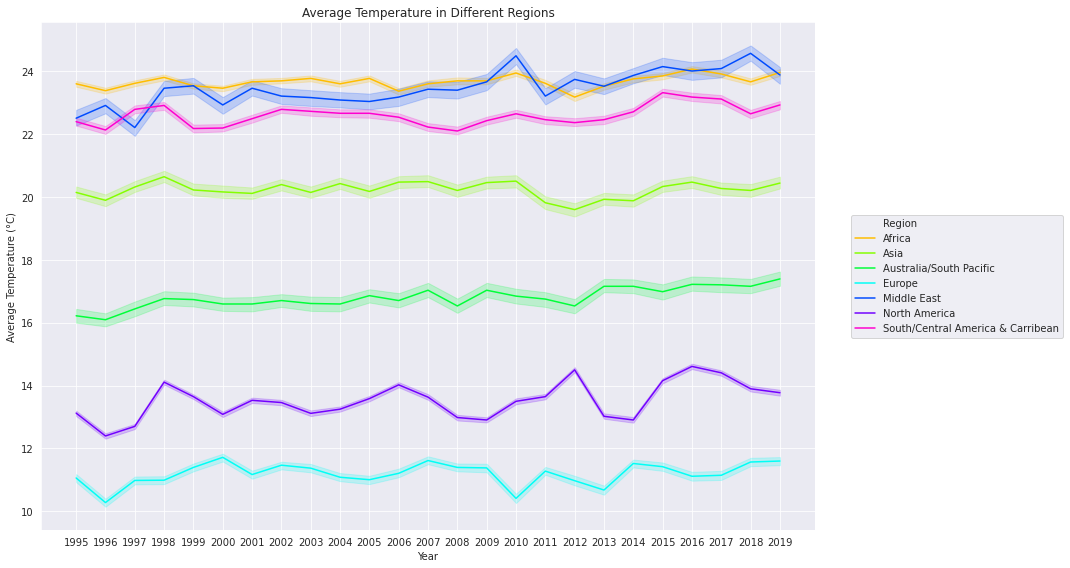

In [37]:
f = plt.figure(figsize=(15,8))
sns.lineplot(x = 'Year', y = 'AvgTempCelsius', hue = 'Region', data = df , palette='hsv')
plt.title('Average Temperature in Different Regions')
plt.ylabel('Average Temperature (°C)')
plt.xlabel('Year')
plt.xticks(range(1995,2020))
plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.5),ncol=1)
plt.tight_layout()
plt.show();

#### DISTRIBUTION OF TEMPERATURES IN DIFFERENT REGIONS

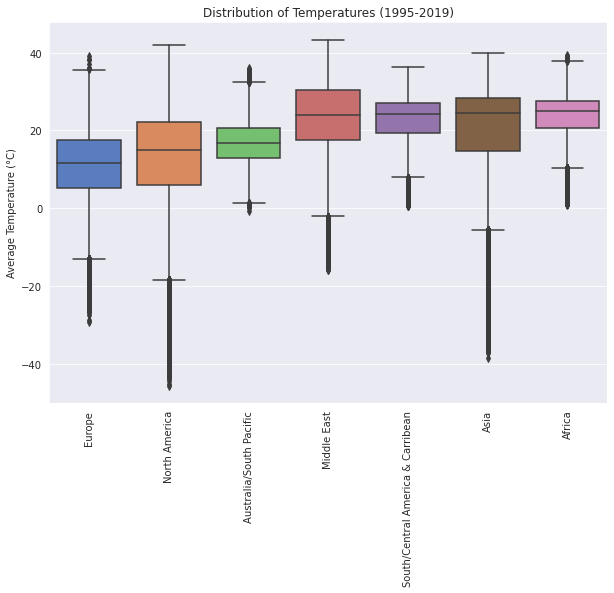

In [38]:
region_sorted = df.groupby('Region')['AvgTempCelsius'].median().sort_values().index

with sns.color_palette("muted"):
    f, ax = plt.subplots(figsize=(10, 7))
    sns.boxplot(data = df.sort_values("AvgTempCelsius"), x = 'Region', y = 'AvgTempCelsius', order = region_sorted)
    plt.xticks(rotation = 90)
    plt.title('Distribution of Temperatures (1995-2019)')
    plt.xlabel('')
    plt.ylabel('Average Temperature (°C)')

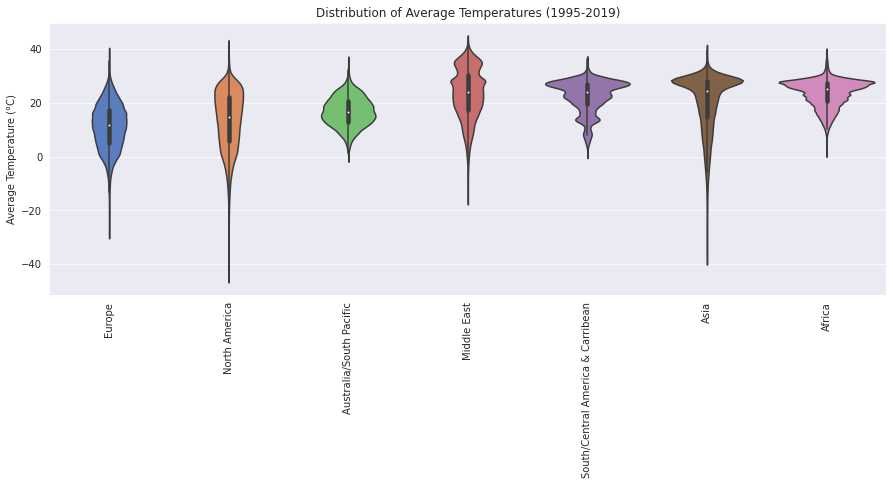

In [39]:
with sns.color_palette("muted"):
    f, ax = plt.subplots(figsize=(15, 5))
    sns.violinplot(data = df.sort_values("AvgTempCelsius"), x = 'Region', y = 'AvgTempCelsius_rounded', order = region_sorted)
    plt.xticks(rotation = 90)
    plt.title('Distribution of Average Temperatures (1995-2019)')
    plt.xlabel('')
    plt.ylabel('Average Temperature (°C)')
    plt.show;

#### MONTHLY AVERAGE TEMPERATURE IN DIFFERENT REGIONS

In [40]:
regions = df.Region.unique().tolist()

In [41]:
import matplotlib.gridspec as gridspec

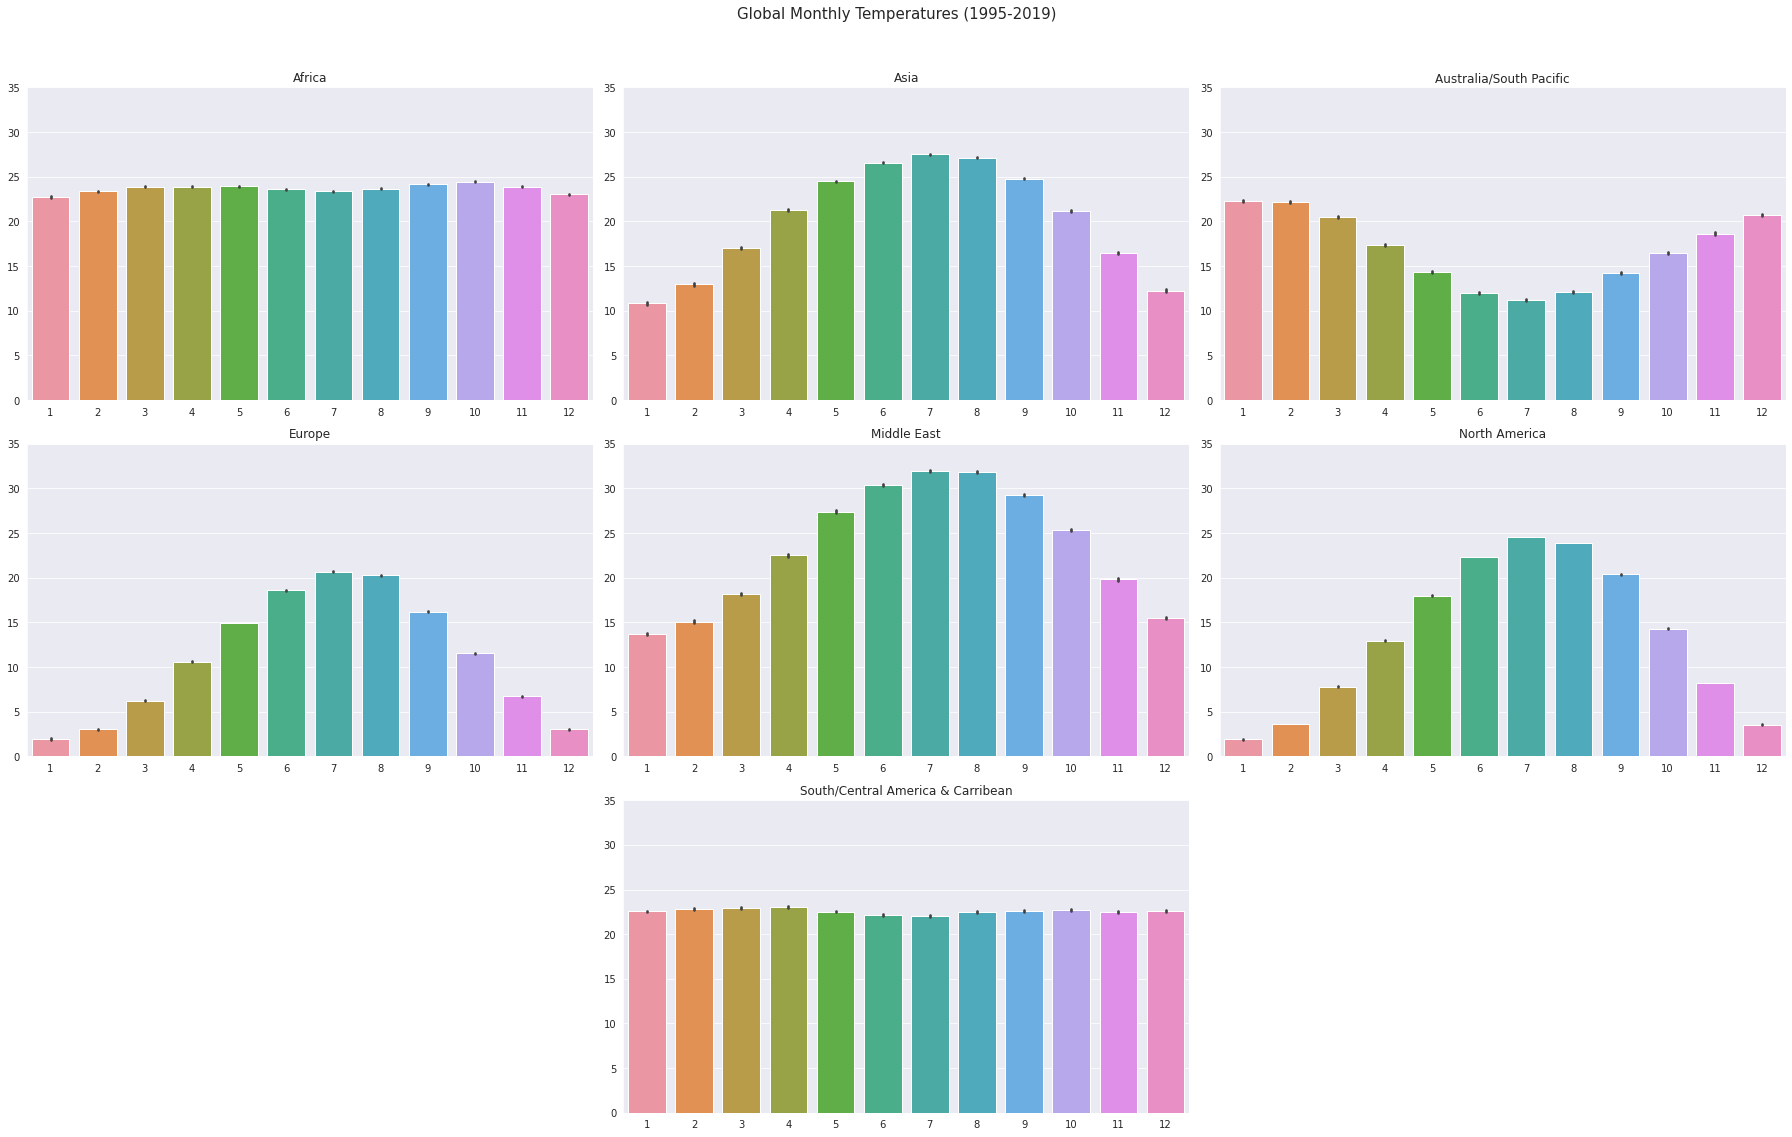

In [42]:
number_plot = [0, 0, 0, 1, 1, 1, 2]
position_a = [0, 2, 4, 0, 2, 4, 2]
position_b = [2, 4, 6, 2, 4, 6, 4]

fig = plt.figure(figsize = (25,15))
plt.suptitle('Global Monthly Temperatures (1995-2019)', y = 1.05, fontsize=15)

gs = gridspec.GridSpec(3, 6)

for i in range(7): 
    #ax = plt.subplot(3, 3, i+1)
    ax = plt.subplot(gs[number_plot[i], position_a[i]:position_b[i]])
    sns.barplot(x = 'Month', y = 'AvgTempCelsius_rounded2', data = df[df.Region == regions[i]])
    ax.title.set_text(regions[i])
    ax.set_ylim((0,35))
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.subplots_adjust(wspace = 0.5)

plt.savefig('demographics.png')
plt.tight_layout()
plt.show();

#### TOP 10 HOTTEST COUNTRIES

In [43]:
s = df.groupby(['Country'])['AvgTempCelsius'].mean().reset_index().sort_values(by='AvgTempCelsius',ascending=False)[:10]
s.style.background_gradient(cmap="Reds")

,Country,AvgTempCelsius
44,Haiti,29.828125
108,Thailand,28.843750
78,Nigeria,28.734375
50,Indonesia,28.593750
117,United Arab Emirates,28.531250
43,Guyana,28.515625
81,Oman,28.453125
88,Qatar,28.390625
42,Guinea-Bissau,28.031250
85,Philippines,27.968750


#### TOP 10 COLDEST COUNTRIES

In [44]:
s = df.groupby(['Country'])['AvgTempCelsius'].mean().reset_index().sort_values(by='AvgTempCelsius',ascending=True)[:10]
s.style.background_gradient(cmap="Blues")

,Country,AvgTempCelsius
70,Mongolia,-0.833984
48,Iceland,5.343750
80,Norway,5.480469
18,Canada,5.875000
33,Finland,5.976562
14,Bolivia,7.488281
62,Latvia,7.492188
102,Sweden,7.605469
9,Belarus,7.652344
90,Russia,7.718750


### Europe

In [45]:
df_europe = df[df.Region == 'Europe'].copy()

In [46]:
df_europe.sample(5)

,Region,Country,City,Month,Day,Year,Date,AvgTempCelsius,AvgTempCelsius_rounded,AvgTempCelsius_rounded2
721966,Europe,France,Bordeaux,10,8,1995,1995-10-01,18.781250,18.78,18.8
732939,Europe,Germany,Bonn,6,10,2000,2000-06-01,19.453125,19.45,19.5
944633,Europe,Switzerland,Bern,4,21,2006,2006-04-01,14.617188,14.62,14.6
998779,Europe,Yugoslavia,Belgrade,5,2,2002,2002-05-01,21.562500,21.56,21.6
694147,Europe,Denmark,Copenhagen,9,17,1995,1995-09-01,11.945312,11.95,11.9


#### DISTRIBUTION OF  TEMPERATURES IN EUROPE

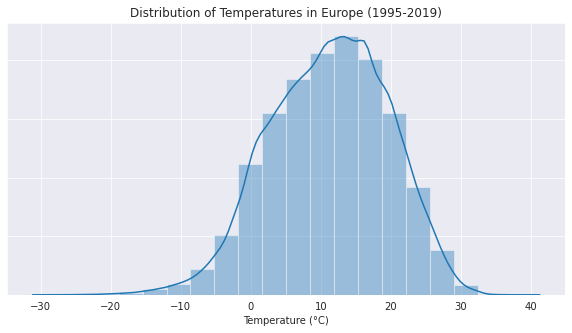

In [47]:
f, ax = plt.subplots(figsize=(10, 5))
sns.distplot(df_europe.AvgTempCelsius_rounded, bins = 20)
plt.title('Distribution of Temperatures in Europe (1995-2019)')
plt.xlabel('Temperature (°C)')
#ax.axes.yaxis.set_visible(False)
ax.axes.yaxis.set_ticklabels(['']);

#### DISTRIBUTION OF TEMPERATURES IN EUROPE IN 2019

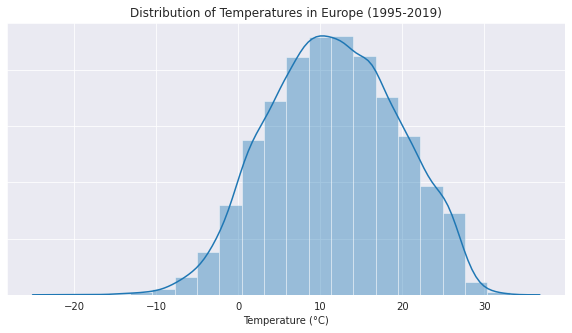

In [48]:
f, ax = plt.subplots(figsize=(10, 5))
sns.distplot(df_europe[df_europe.Year == 2019].AvgTempCelsius_rounded, bins = 20)
plt.title('Distribution of Temperatures in Europe (1995-2019)')
plt.xlabel('Temperature (°C)')
#ax.axes.yaxis.set_visible(False)
ax.axes.yaxis.set_ticklabels(['']);

#### DISTRIBUTION OF TEMPERATURES IN DIFFERENT EUROPEAN COUNTRIES

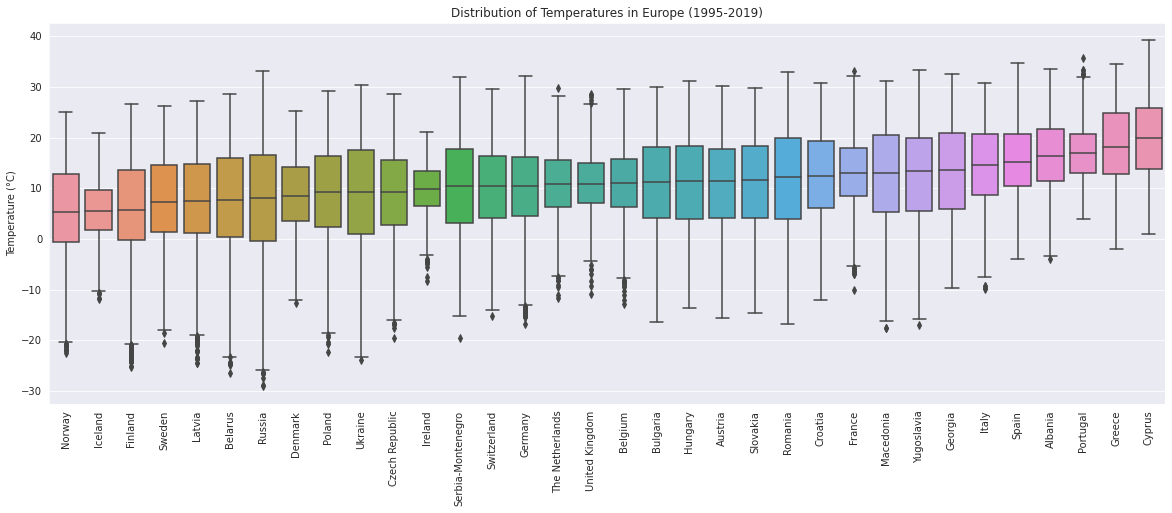

In [49]:
countries_sorted = df_europe.groupby('Country')['AvgTempCelsius_rounded2'].median().sort_values().index

with sns.color_palette("muted"):
    f, ax = plt.subplots(figsize=(20, 7))
    sns.boxplot(data = df_europe, x = 'Country', y = 'AvgTempCelsius_rounded', order = countries_sorted)
    plt.xticks(rotation = 90)
    plt.title('Distribution of Temperatures in Europe (1995-2019)')
    plt.ylabel('Temperature (°C)')
    plt.xlabel('');

#### AVERAGE TEMPERATURE IN DIFFERENT EUROPEAN COUNTRIES

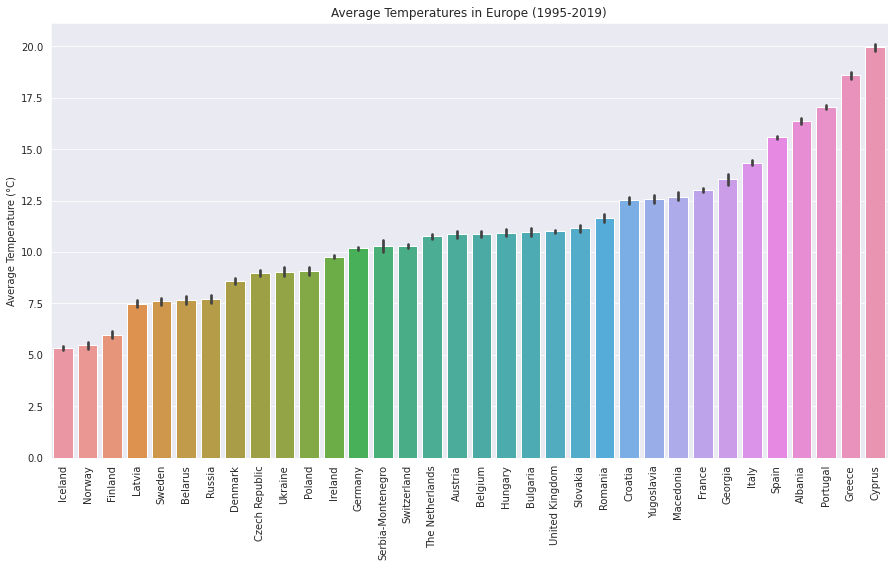

In [50]:
countries_mean_sorted = df_europe.groupby('Country').AvgTempCelsius_rounded2.mean().sort_values().index

plt.figure(figsize = (15,8))
sns.barplot(x = 'Country', y = 'AvgTempCelsius_rounded2', data = df_europe, 
            order = countries_mean_sorted)
plt.xticks(rotation = 90)
plt.xlabel('')
plt.title('Average Temperatures in Europe (1995-2019)')
plt.ylabel('Average Temperature (°C)');

#### AVERAGE TEMPERATURE IN EUROPE OVER TIME 

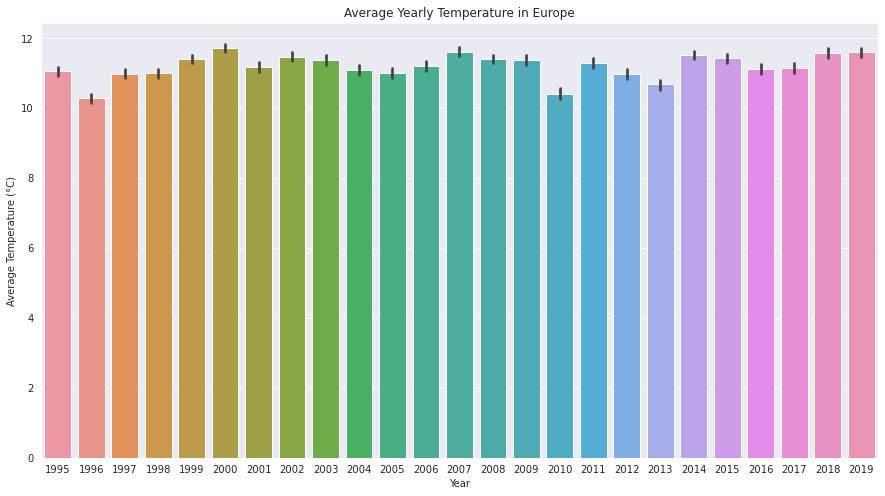

In [51]:
plt.figure(figsize = (15,8))
sns.barplot(x = 'Year', y = 'AvgTempCelsius_rounded2', data = df_europe)
plt.title('Average Yearly Temperature in Europe')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.show();

#### MONTHLY AVERAGE TEMPERATURE IN EUROPE OVER TIME

In [52]:
europe_mean_month = df_europe.groupby(['Month', 'Year']).AvgTempCelsius_rounded2.mean()
europe_mean_month = europe_mean_month.reset_index()
europe_mean_month = europe_mean_month.sort_values(by = ['Year'])

In [53]:
europe_pivoted = pd.pivot_table(data= europe_mean_month,
                    index='Month',
                    values='AvgTempCelsius_rounded2',
                    columns='Year')

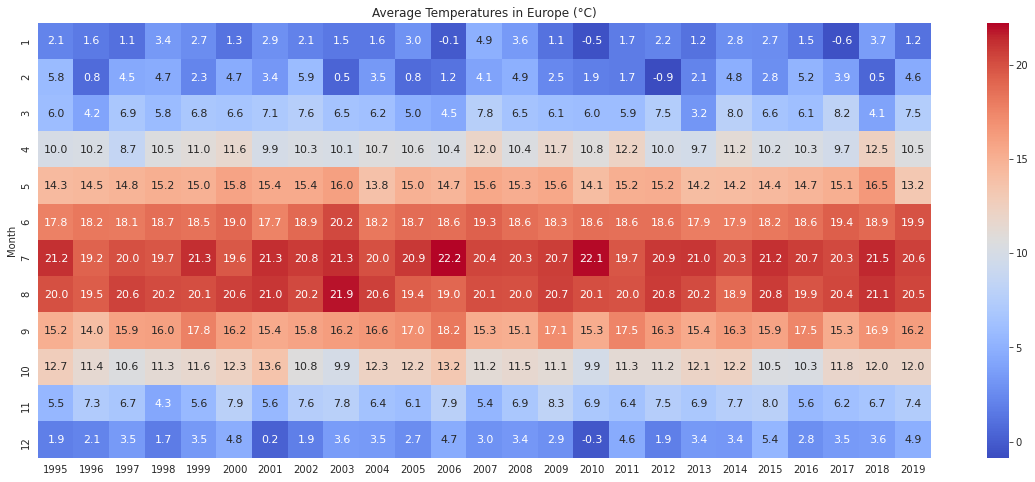

In [54]:
plt.figure(figsize=(20, 8))
sns.heatmap(data = europe_pivoted, cmap='coolwarm', annot = True, fmt=".1f", annot_kws={'size':11})
plt.ylabel('Month')
plt.xlabel('')
plt.title('Average Temperatures in Europe (°C)')
plt.show();

### Austria

In [55]:
df_austria = df_europe[df_europe.Country == 'Austria'].copy()

In [56]:
df_austria.head()

,Region,Country,City,Month,Day,Year,Date,AvgTempCelsius,AvgTempCelsius_rounded,AvgTempCelsius_rounded2
632643,Europe,Austria,Vienna,1,1,1995,1995-01-01,2.048828,2.05,2.0
632644,Europe,Austria,Vienna,1,2,1995,1995-01-01,1.493164,1.49,1.5
632645,Europe,Austria,Vienna,1,3,1995,1995-01-01,-0.329834,-0.33,-0.3
632646,Europe,Austria,Vienna,1,4,1995,1995-01-01,-3.777344,-3.78,-3.8
632647,Europe,Austria,Vienna,1,5,1995,1995-01-01,-5.000000,-5.00,-5.0


#### DISTRIBUTION OF TEMPERATURES IN AUSTRIA

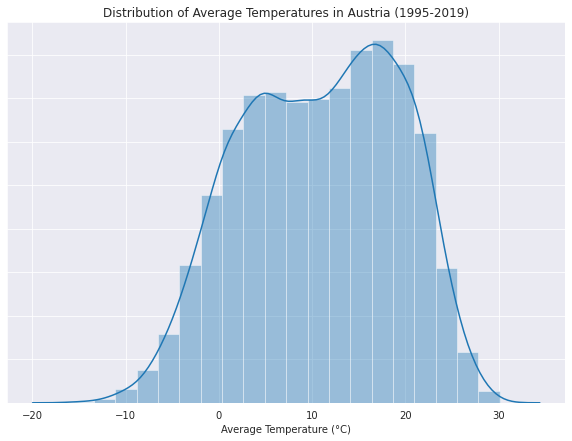

In [57]:
f, ax = plt.subplots(figsize=(10, 7))
sns.distplot(df_austria.AvgTempCelsius_rounded, bins = 20);
plt.title('Distribution of Average Temperatures in Austria (1995-2019)')
plt.xlabel('Average Temperature (°C)')
ax.axes.yaxis.set_ticklabels([]);

#### YEARLY AVERAGE TEMPERATURE IN AUSTRIA OVER TIME

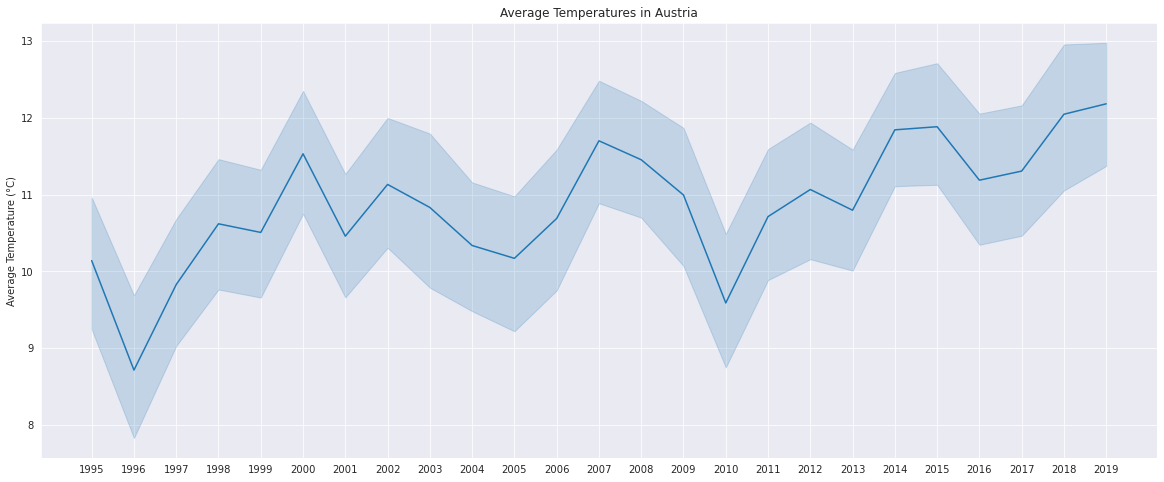

In [58]:
plt.figure(figsize=(20,8))
sns.lineplot(x = 'Year', y = 'AvgTempCelsius_rounded2', data = df_austria , palette='hsv')
plt.title('Average Temperatures in Austria')
plt.ylabel('Average Temperature (°C)')
plt.xlabel('')
plt.xticks(range(1995,2020))
plt.show()

#### MONTHLY AVERAGE TEMPERATURE IN AUSTRIA

In [59]:
years = df_austria.Year.unique().tolist()
years = [str(year) for year in years]

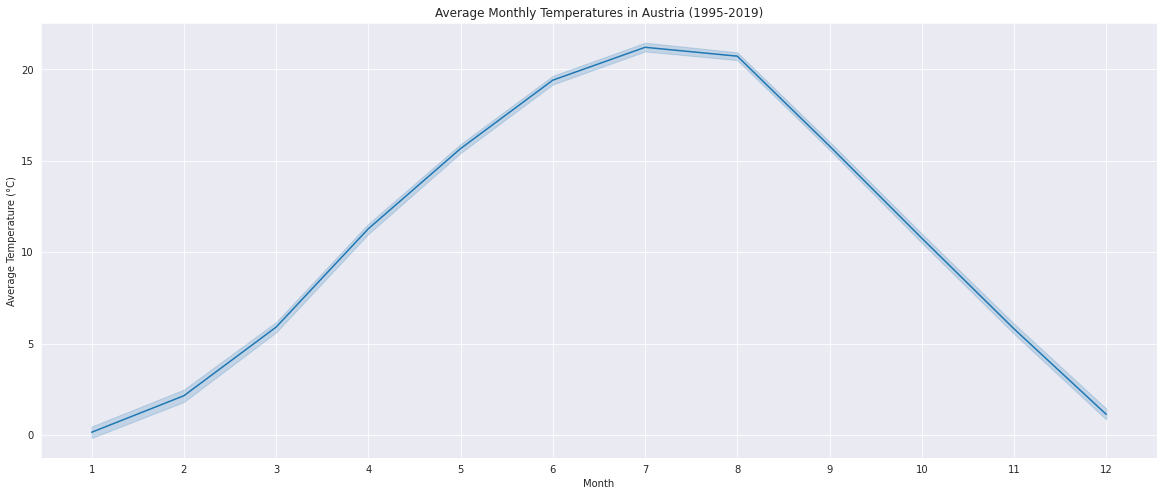

In [60]:
plt.figure(figsize=(20,8))
sns.lineplot(x = 'Month', y = 'AvgTempCelsius_rounded2', data = df_austria , palette='hsv')
plt.title('Average Monthly Temperatures in Austria (1995-2019)')
plt.ylabel('Average Temperature (°C)')
plt.xlabel('Month')
plt.xticks(range(1,13))
plt.show();

#### MONTHLY AVERAGE TEMPERATURE IN AUSTRIA (DETAILED)

In [61]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']

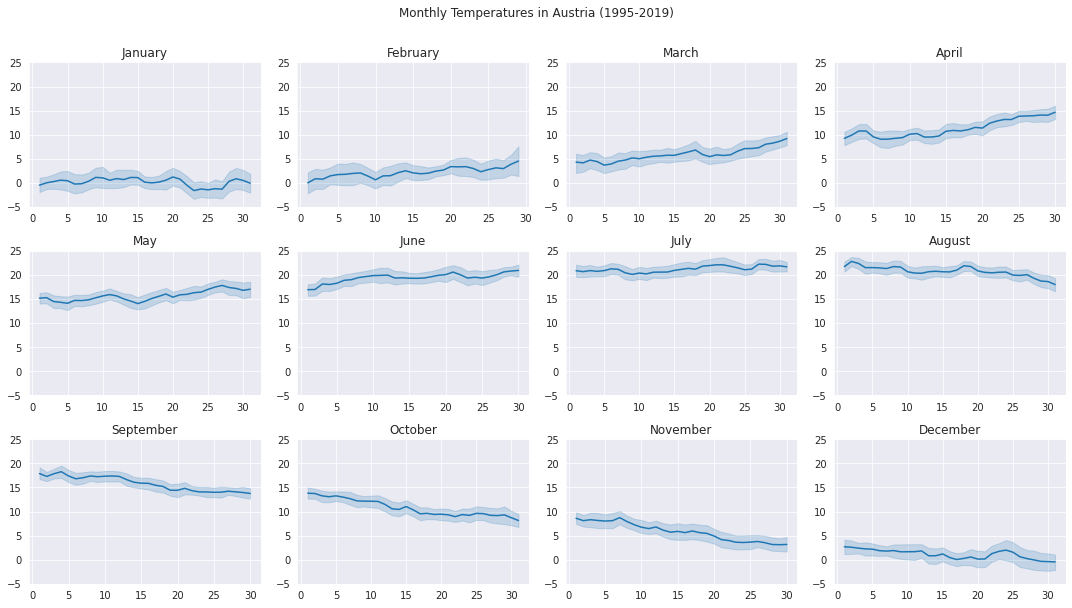

In [62]:
fig = plt.subplots(3,4, figsize = (15,8))
for i in range(1,13): 
    ax = plt.subplot(3, 4, i)
    sns.lineplot(x = 'Day', y = 'AvgTempCelsius_rounded2', data = df_austria[df_austria.Month == i] , palette='hsv')
    ax.title.set_text(months[i-1])
    ax.set_ylim((-5,25))
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.suptitle('Monthly Temperatures in Austria (1995-2019)', y = 1.05)
#plt.ylabel('Average Temperature (°C)')
plt.tight_layout()
plt.show();

#### MONTHLY AVERAGE TEMPERATURE IN AUSTRIA OVER TIME

In [63]:
austria_pivoted = pd.pivot_table(data= df_austria,
                    index='Month',
                    values='AvgTempCelsius_rounded2',
                    columns='Year')

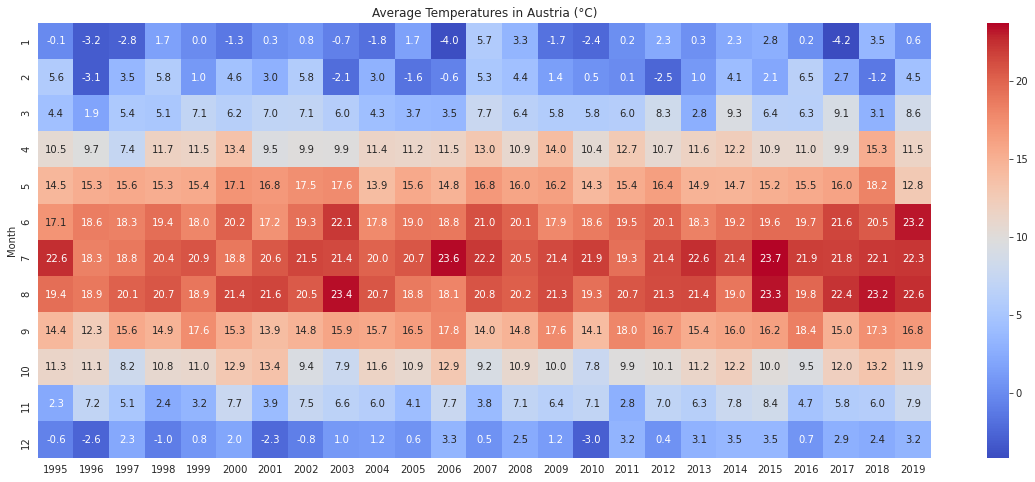

In [64]:
plt.figure(figsize=(20, 8))
sns.heatmap(data = austria_pivoted, cmap='coolwarm', annot = True, fmt=".1f")
plt.ylabel('Month')
plt.xlabel('')
plt.title('Average Temperatures in Austria (°C)')
plt.show();